# Calibration

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z  in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

#data path
'000260'
'000333'
'20-1586'
'400'
'29-1289'
'data file numerations are like [20:1586:5]'
data_path="/home/ema/Uni/LCPa/LCPa_Project/180904/Run000333/data_000000.txt"
half_path="/home/ema/Uni/LCPa/LCPa_Project/180904/Run000333/data_"
data_paths=[half_path+str(i).zfill(6)+'.txt' for i in range(20,1586,5)]

#best detectors configuration for a given run ([2,3] or [0,1]?)
calib_config=[0,1,2,3]

In [3]:
cal1={}
false_events_counter=0
for data_path in data_paths:
    with open(data_path) as data_file:
        for line in data_file:
            row=line.strip().split()
            key=int(row[0])
            n_hits=int(row[1])
            if n_hits!=0:
                data_array=np.array(row[2:]).reshape((n_hits, 5))
                data_dict={}
                columns=['chamber', 'layer', 'xleft', 'xright', 'time']
                for i in range(2):
                    data_dict[columns[i]]=data_array[:, i].astype(int)
                for i in range(2,5):
                    data_dict[columns[i]]=data_array[:, i].astype(float)
                value=pd.DataFrame(data_dict)
                cal1[key]=value
            else:
                false_events_counter+=1
original_data_length=len(cal1)+false_events_counter
print(f'original data length: {original_data_length}')
print(f"null over nonnull events ratio (%) : {false_events_counter/(len(cal1)+false_events_counter)*100}%")

original data length: 60200
null over nonnull events ratio (%) : 24.66279069767442%


In [4]:
for event in cal1.values():
    event['xrg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xleft'], axis=1)
    event['xlg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xright'], axis=1)
    event['zg']=event.apply(lambda df: global_z_shifts[int(df['chamber'])]-local_z_shifts[int(df['layer'])-1]+4*ZCELL-ZCELL/2, axis=1)
    event['center']=(event['xlg']+event['xrg'])/2
    event['valid_hit']=pd.Series(np.ones(len(event)).astype(bool))

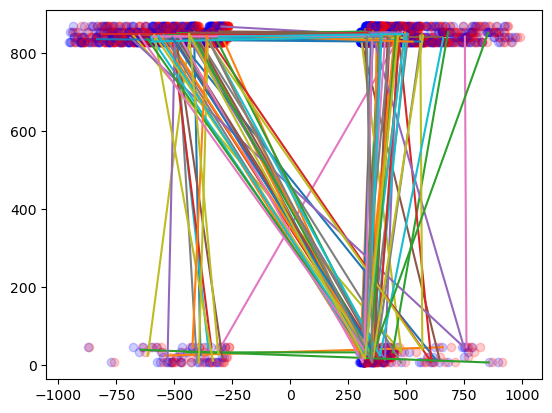

In [5]:
fig, ax=plt.subplots()
count=0
for event in cal1.values():
    ax.scatter(event['xlg'], event['zg'], color='blue', alpha=0.2)
    ax.scatter(event['xrg'], event['zg'], color='red', alpha=0.2)
    ax.plot((event.groupby('chamber').mean().reset_index()['xlg']+event.groupby('chamber').mean().reset_index()['xlg'])/2, event.groupby('chamber').mean().reset_index()['zg'], '-')
    count+=1
    if(count>=100):
        break
#ax.set_xlim(-450, -405)
plt.show()

[(12008, '[0, 2]'), (8218, '[0, 1, 2]'), (6602, '[0]'), (5873, '[2]'), (2465, '[0, 1, 2, 3]'), (2404, '[0, 1]'), (1622, '[1, 2]'), (1471, '[0, 2, 3]'), (1405, '[1]'), (1219, '[2, 3]'), (926, '[3]'), (420, '[0, 3]'), (350, '[1, 2, 3]'), (234, '[0, 1, 3]'), (136, '[1, 3]')]
('[0, 2]', '[0, 1, 2]', '[0]', '[2]', '[0, 1, 2, 3]', '[0, 1]', '[1, 2]', '[0, 2, 3]', '[1]', '[2, 3]', '[3]', '[0, 3]', '[1, 2, 3]', '[0, 1, 3]', '[1, 3]') (12008, 8218, 6602, 5873, 2465, 2404, 1622, 1471, 1405, 1219, 926, 420, 350, 234, 136)


Text(0.5, 1.0, 'number of events for any combination of triggered chambers')

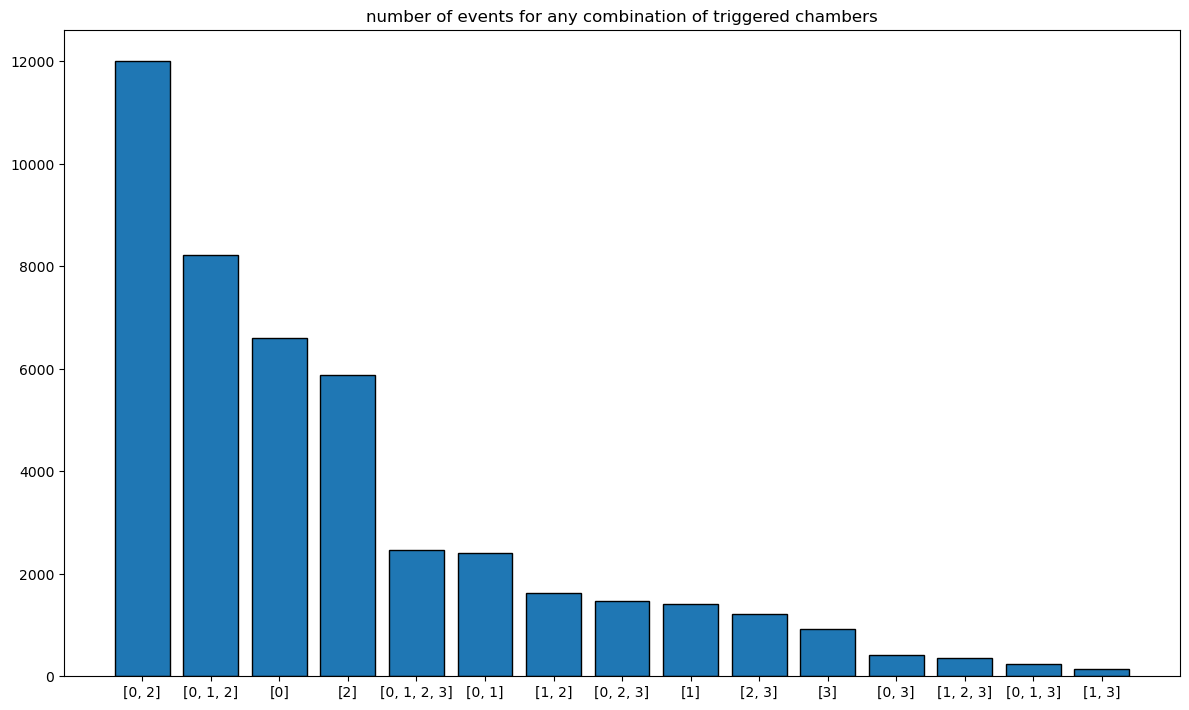

In [6]:
fig,ax=plt.subplots(figsize=(12,7))
bins, counts=(np.unique([str(sorted(np.unique(event['chamber']))) for event in cal1.values()], return_counts=True))
zipped=zip(counts, bins)
sortedzipped=sorted(zipped, reverse=True)
print(sortedzipped)
[counts, bins]=zip(*sortedzipped)
print(bins, counts)
ax.bar(bins, counts, edgecolor='black')
fig.tight_layout()
ax.set_title('number of events for any combination of triggered chambers')

average n_hits per event: 34.57728194726166
 most frequent n_hits per event 15



Text(0.5, 1.0, 'number of events vs number of hits for the [0, 1, 2, 3] chambers events')

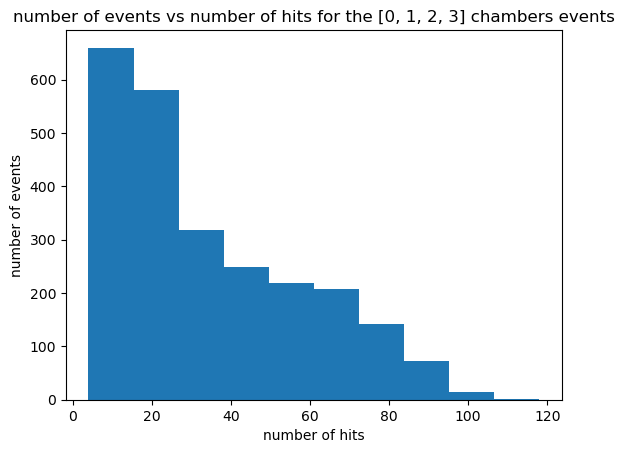

In [7]:
n_hits_per_event=[len(event) for event in cal1.values() if sorted(np.unique(event['chamber']))==calib_config]
print(f'average n_hits per event: {np.mean(n_hits_per_event)}')
print(f' most frequent n_hits per event {np.unique(n_hits_per_event)[np.argmax(np.unique(n_hits_per_event, return_counts=True)[1])]}')
#plt.hist(n_hits_per_event, bins=33)
plt.hist(n_hits_per_event)
print()
plt.xlabel('number of hits')
plt.ylabel('number of events')
plt.title(f'number of events vs number of hits for the {calib_config} chambers events')

In [8]:
'''
print(not np.any(np.array(cal1[4].groupby('chamber').count().reset_index()['layer']<3)))
print(cal1[4])
'''

"\nprint(not np.any(np.array(cal1[4].groupby('chamber').count().reset_index()['layer']<3)))\nprint(cal1[4])\n"

In [9]:
print(list((np.abs(event['xleft']-event['xright'])>XCELL).index))
print(cal1[1].index)

[0, 1, 2, 3, 4, 5, 6]
RangeIndex(start=0, stop=18, step=1)


In [10]:
#filters for event selection

def desired_chamber_config(event):
    '''
    print('DCC event: ',event[event['valid_hit']==True])
    print('DCC chamber col', event[event['valid_hit']==True]['chamber'])
    print('DCC config', sorted(np.unique(event[event['valid_hit']==True]['chamber'])))
    '''
    return sorted(np.unique(event['chamber']))==calib_config

def desired_chamber_config_only_valids(event):
    return sorted(np.unique(event[event['valid_hit']==True]['chamber']))==calib_config

def three_layers_per_det(event):
    return not np.any(event[event['valid_hit']==True].groupby('chamber')['layer'].nunique().reset_index()['layer']<3) and desired_chamber_config_only_valids(event)

def one_hit_per_layer(event):
    return not np.any(event.groupby(['chamber', 'layer']).count().reset_index()['time']!=1)

def max_two_hits_per_layer(event):
    return not np.any(event.groupby(['chamber', 'layer']).count().reset_index()['time']>2)

def max_two_layers_with_more_than_one_hit(event):
    return not np.count_nonzero(event.groupby(['chamber', 'layer']).count().reset_index()['time']>1)>2

    '''
    print('1', np.array(event['valid_hit']==True))
    print('2', np.array(event[event['valid_hit']==True].groupby('chamber')['layer']))
    print('3', event[event['valid_hit']==True].groupby('chamber')['layer'].value_counts().reset_index())
    print('4', np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].value_counts().reset_index()))
    print('5', np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].reset_index()).unique(return_counts=True)[1])
    print('6', np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].reset_index()).unique(return_counts=True)[1]>1)
    print('7', (np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].reset_index()).unique(return_counts=True)[1]>1).count()<=2)
    return (np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].reset_index()).unique(return_counts=True)[1]>1).count()<=2
    '''

#filters for (bad) hit selection

def coordinates_outside_cell(event):
    return list(event[np.abs(event['xleft']-event['xright'])>XCELL].index)

def deviant_hit(event): 
    n_sigmas_treshhold=2
    bad_indices=[]
    def other_hits_mu_std(out_index, event):
        index=list(event[event['chamber']==event.loc[out_index]['chamber']].index)
        index.remove(out_index)
        print('index', index)
        return event.loc[index]['center'].mean(), event.loc[index]['center'].std() 
        
    for out_index, row in event.iterrows():
        print('out_index', out_index)
        mu, std=other_hits_mu_std(out_index, event)
        print(row['center'], mu, abs(row['center']-mu), n_sigmas_treshhold*std, XCELL)
        if abs(row['center']-mu)> max(n_sigmas_treshhold*std, XCELL):
            bad_indices.append(out_index)
    return bad_indices

#filter applicators:

def event_filter(keys_list, e_filter): #modifies the list of keys
    return list(filter(lambda key : e_filter(cal1[key]), keys_list))

def hit_filter(keys_list, h_filter): #modifies in place the 'valid_hit' column of dataset
    for key in keys_list:
        event=cal1[key]
        #the "bad" filters return lists of "bad" hit indices, to be set to false. So the lists can just be concatenate with "+"
        bad_rows_indices_list=h_filter(event)
        print('badrowsindes: ',key, bad_rows_indices_list)
        #print('before:', event)
        event.loc[bad_rows_indices_list,'valid_hit'] = False
        #print('after:', event)


In [11]:
#FILTERS APPLICATION (both event_filters and hit_filters):
#NB: THE ORDER MATTERS!
impeccable_events=event_filter(cal1, desired_chamber_config)
impeccable_events=event_filter(impeccable_events, max_two_layers_with_more_than_one_hit)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
hit_filter(impeccable_events, coordinates_outside_cell)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
hit_filter(impeccable_events, deviant_hit)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
impeccable_events=event_filter(impeccable_events, three_layers_per_det)
#impeccable_events=event_filter(cal1, desired_chamber_config)

print(impeccable_events)
print(len(impeccable_events))
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")

ratio between impeccable events and nonzerohit events 0.011708156020549908
 ratio between impeccable events and original dataset events 0.008820598006644519
badrowsindes:  13 []
badrowsindes:  366 []
badrowsindes:  481 []
badrowsindes:  699 []
badrowsindes:  1236 []
badrowsindes:  1658 [5]
badrowsindes:  1769 []
badrowsindes:  1822 []
badrowsindes:  1823 [4]
badrowsindes:  1906 []
badrowsindes:  2129 []
badrowsindes:  2393 []
badrowsindes:  2601 []
badrowsindes:  2799 []
badrowsindes:  2816 []
badrowsindes:  3044 []
badrowsindes:  3070 [2, 3]
badrowsindes:  3142 []
badrowsindes:  3237 []
badrowsindes:  3297 []
badrowsindes:  3415 []
badrowsindes:  3554 []
badrowsindes:  3629 [7]
badrowsindes:  3742 []
badrowsindes:  4025 []
badrowsindes:  4683 []
badrowsindes:  4735 []
badrowsindes:  4830 []
badrowsindes:  4944 []
badrowsindes:  4980 []
badrowsindes:  5196 []
badrowsindes:  5299 []
badrowsindes:  5457 []
badrowsindes:  5699 []
badrowsindes:  5721 []
badrowsindes:  5757 []
badrowsindes:

In [12]:

event=cal1[4944]
#print( 'mu std', event.loc[[7,8,9]]['center'].mean(), event.loc[[7,8,9]]['center'].std() )
print(event)
print()
hit_filter([4944], coordinates_outside_cell)
#event_plotter(2)
print(coordinates_outside_cell(event))
print(event)
print('!!!', max_two_layers_with_more_than_one_hit(event))

    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      1  603.70  614.30   98.8  390.50  379.90  869.0  385.200   
1         0      3  601.90  616.10  131.3  392.30  378.10  843.0  385.200   
2         0      4  616.30  643.70  253.8  377.90  350.50  830.0  364.200   
3         1      1  607.90  610.10   21.3  339.50  337.30   45.5  338.400   
4         1      3  607.60  610.40   26.3  339.80  337.00   19.5  338.400   
5         1      2  610.10  649.90  368.8  337.30  297.50   32.5  317.400   
6         1      4  611.50  648.50  343.8  335.90  298.90    6.5  317.400   
7         2      3  100.30  109.70   88.0 -367.70 -377.10  843.0 -372.400   
8         2      2   75.49   92.51  158.0 -342.89 -359.91  856.0 -351.400   
9         2      4   69.21   98.79  274.6 -336.61 -366.19  830.0 -351.400   
10        2      1  425.10  456.90  295.5 -692.50 -724.30  869.0 -708.400   
11        3      3   60.46   65.54   47.1 -321.96 -327.04   19.5 -324.500   

In [13]:

print(cal1[95]['layer'].unique())
print(cal1[95])


[3 2 1 4]
    chamber  layer  xleft  xright   time    xrg    xlg     zg  center  \
0         0      3  482.2   483.8   14.6  512.0  510.4  843.0   511.2   
1         0      2  625.3   634.7   88.0  368.9  359.5  856.0   364.2   
2         0      2  670.0   674.0   37.1  324.2  320.2  856.0   322.2   
3         0      1  471.4   494.6  215.5  522.8  499.6  869.0   511.2   
4         0      4  623.6   636.4  118.8  370.6  357.8  830.0   364.2   
5         0      1  634.5   667.5  307.1  359.7  326.7  869.0   343.2   
6         0      4  487.5   520.5  307.1  506.7  473.7  830.0   490.2   
7         0      3  634.7   667.3  302.1  359.5  326.9  843.0   343.2   
8         0      2  445.6   478.4  305.5  548.6  515.8  856.0   532.2   
9         1      4  624.3   635.7  106.3  323.1  311.7    6.5   317.4   
10        2      2  166.8   169.2   22.1 -434.2 -436.6  856.0  -435.4   
11        2      4  207.2   212.8   51.3 -474.6 -480.2  830.0  -477.4   
12        2      3  272.3   273.7   12.1 

In [31]:
from itertools import product
from scipy.stats import pearsonr
from math import atan2


def angle(A,B, C=None):
    #takes two points A and B with coordinates A=(xA,yA)... and return the angle on the plane in radiants
    #OR takes three points A, B, C with coordinates A=(xA,yA).. and return the difference angle BC^-AB^
    if C==None:
        return np.pi/2-atan2(A[1]-B[1], A[0]-B[0])
    else:
        difference=np.abs(angle(B,C)-angle(A,B))
        return min(2*np.pi-difference, difference)

def zigzaginess(path):
    try:
        if(len(path)>=3):
            squaresum=0
            for i in range(len(path)-2):
                A=path[i]
                B=path[i+1]
                C=path[i+2]
                squaresum+=(angle(B,C)-angle(A,B))**2
            return squaresum
        else:
            raise Exception("Error: path of less than 3 points")
    except Exception as err:
        print(err)
    
def tangent_zigzaginess(path):
    try:
        if(len(path)>=3):

            deviation_sum=0
            length_sum=0

            for i in range(len(path)-2):
                A=path[i]
                B=path[i+1]
                C=path[i+2]
                deviation_sum+=(atan2(B[0]-C[0], B[1]-C[1])-atan2(A[0]-B[0], A[1]-B[1]))**2

            for i in range(len(path)-1):
                A=path[i]
                B=path[i+1]
                length_sum+=(B[0]-A[0])**2+(B[1]-A[1])**2
            length_weight=0.5

            A,B,C,D=path[0], path[1], path[-2], path[-1]
            first_last_deviation=(atan2(C[0]-D[0], C[1]-D[1])-atan2(A[0]-B[0], A[1]-B[1]))**2
            fldev_weight=1

            return deviation_sum+fldev_weight*first_last_deviation+length_weight*length_sum
        else:
            raise Exception("Error: path of less than 3 points")
    except Exception as err:
        print(err)

def opt_track(event, chamber):
    valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]
    valid_subevent=valid_subevent.sort_values(by='zg')

    axes=[]
    for layer in np.sort(valid_subevent['layer'].unique()):
        axis=[]
        for index, row in valid_subevent[event['layer']==layer].iterrows():
            for coord in [row['xlg'], row['xrg']]:
                axis.append((coord, row['zg']))
        axes.append(axis)

    #axes=[['xrg', 'xlg']]*len(valid_subevent)
    paths=list(product(*axes))
    
    #paths=[[(np.array(valid_subevent[xc[i]])[i], np.array(valid_subevent['zg'])[i] ) for i in range(len(valid_subevent))] for xc in xcs]
    #sorting_function=(lambda path : abs(pearsonr(*zip(*path)).pvalue))
    #sorting_function=(lambda path : abs(np.corrcoef(*zip(*path))[0,1]))
    straightness_function=lambda x: -tangent_zigzaginess(x)
    best_path=max(paths, key=straightness_function)
    return best_path

In [32]:
from matplotlib.patches import Rectangle
from scipy.stats import linregress

def event_plotter(event_number, plot_ax=None):
    my_event=cal1[event_number]
    x_centers, z_centers=(my_event['xlg']+my_event['xrg'])/2, my_event['zg']
    if plot_ax==None:
        fig, ax=plt.subplots(figsize=(12,10))
    else:
        ax=plot_ax

    #drawing the detectors   
    for i in range(4):
        x_origs=np.array(global_x_shifts)-700
        z_origs=global_z_shifts
        detector=Rectangle([x_origs[i], z_origs[i]], 700, 4*ZCELL, edgecolor='gray', facecolor='white')
        ax.add_artist(detector)

    #drawing the triggered cells
    for i in range(len(my_event)):
        rect=Rectangle([x_centers[i]-XCELL/2, z_centers[i]-ZCELL/2], XCELL, ZCELL, edgecolor='black', facecolor='white')
        ax.add_artist(rect)

    #drawing the points of hits
    dots_size=int(ax.get_position().width*20)+1
    ax.scatter(my_event['xlg'], my_event['zg'], color='blue', s=dots_size)
    ax.scatter(my_event['xrg'], my_event['zg'], color='red', s=dots_size)
    XRANGE=[-1000, 1000]
    YRANGE=[-100, 950]
    ax.set_xlim(XRANGE)
    ax.set_ylim(YRANGE)
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('z [mm]')
    ax.set_title(f'Event {event_number}', size=16)

    def tracker_fitter(in_line_chambers):
        #print('chamber:', in_line_chambers[0])
        (xu,zu)=zip(*opt_track(my_event, in_line_chambers[0]))
        #print('chamber:', in_line_chambers[1])
        (xd,zd)=zip(*opt_track(my_event, in_line_chambers[1]))
        x=np.concatenate([xu,xd])
        z=np.concatenate([zu,zd])

        resu=linregress(zu,xu)
        resd=linregress(zd,xd)
        res=linregress(z,x)

        xspace=np.linspace(*XRANGE, 1000)
        ax.plot(xspace, 1/resu.slope*xspace-resu.intercept/resu.slope, '--')
        ax.plot(xspace, 1/resd.slope*xspace-resd.intercept/resd.slope, '--')
        ax.plot(xspace, 1/res.slope*xspace-res.intercept/res.slope, color='black')
    
    for i in range(0,len(calib_config),2):
        tracker_fitter(calib_config[i:i+2])

    if plot_ax==None:
        plt.show()

In [33]:
def event_filter_from_fit(event_number):
    event_is_tricky=False
    my_event=cal1[event_number]
    x_centers, z_centers=(my_event['xlg']+my_event['xrg'])/2, my_event['zg']

    def tracker_fitter(in_line_chambers):
        is_tricky=False
        #print('chamber:', in_line_chambers[0])
        (xu,zu)=zip(*opt_track(my_event, in_line_chambers[0]))
        #print('chamber:', in_line_chambers[1])
        (xd,zd)=zip(*opt_track(my_event, in_line_chambers[1]))
        x=np.concatenate([xu,xd])
        z=np.concatenate([zu,zd])

        resu=linregress(zu,xu)
        resd=linregress(zd,xd)
        res=linregress(z,x)

        #criteria for trickyness 
        def angle_criterium(xu,zu,xd,zd,resu,resd,res):
            angle_tresh=np.pi/4
            return abs(np.arctan(resu.slope)-np.arctan(res.slope))>angle_tresh or abs(np.arctan(resd.slope)-np.arctan(res.slope))>angle_tresh
        
        def fit_compatibility_criterium(xu,zu,xd,zd,resu,resd,res):
            comp_index_tresh=3
            comp_index='...'
            return comp_index>comp_index_tresh
        


        #if abs(resu.slope)>ang_coef_tresh or abs(resd.slope)>ang_coef_tresh: event_is_tricky=True
        if angle_criterium(xu,zu,xd,zd,resu,resd,res): is_tricky=True
        #ax.plot(xu,zu)
        #ax.plot(xd,zd)
        return is_tricky
    
    for i in range(0,len(calib_config),2):
        is_tricky=tracker_fitter(calib_config[i:i+2])
        if is_tricky: event_is_tricky=True
    #print(event_number)
    #print(my_event)

    return event_number, event_is_tricky

/tmp/ipykernel_1670457/801498561.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]
/tmp/ipykernel_1670457/801498561.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in valid_subevent[event['layer']==layer].iterrows():


TRICKY EVENTS:  [3237]
precentage of good events showing good agreements between local and global fit: 99.03846153846155%
precentage of events in original dataset showing good agreements between local and global fit: 0.17109634551495018%


/tmp/ipykernel_1670457/741520856.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  ax.plot(xspace, 1/resd.slope*xspace-resd.intercept/resd.slope, '--')
/tmp/ipykernel_1670457/741520856.py:50: RuntimeWarning: invalid value encountered in subtract
  ax.plot(xspace, 1/resd.slope*xspace-resd.intercept/resd.slope, '--')


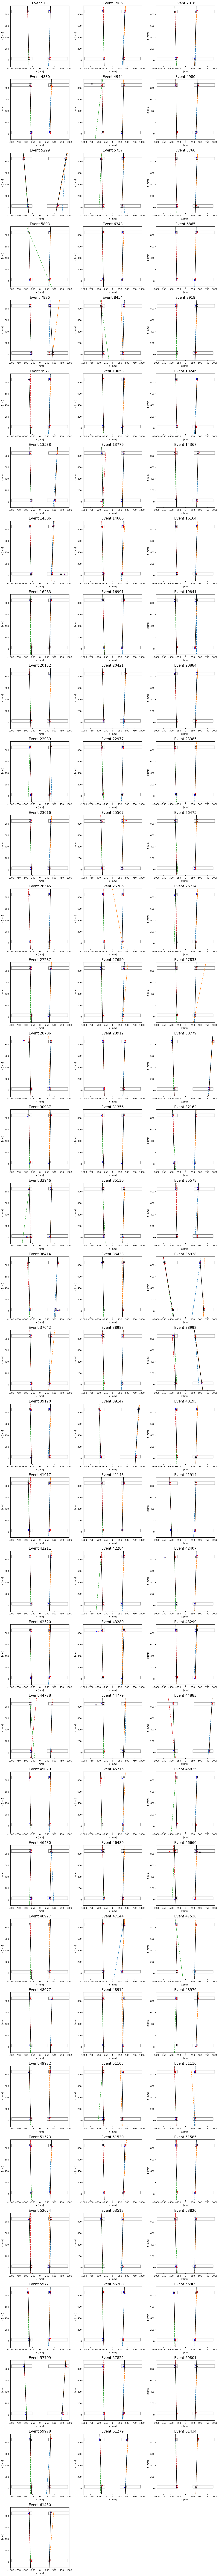

In [34]:
'''
for k in range(min([5, len(impeccable_events)])):
    print(k)
    print(impeccable_events[k])
    print(cal1[impeccable_events[k]])
    event_number, event_is_tricky=event_plotter(impeccable_events[k])
    if event_is_tricky:
        tricky_events.append(event_number)
print('TRICKY EVENTS: ', tricky_events)
print(f'precentage of good events showing good agreements between local and global fit: {(len(impeccable_events)-len(tricky_events))/len(impeccable_events)*100}%')
print(f'precentage of events in original dataset showing good agreements between local and global fit: {(len(impeccable_events)-len(tricky_events))/original_data_length*100}%')
#event_plotter(6577)
#event_plotter(6577)
'''
tricky_events=[]
for event_n in impeccable_events:
    event_number, event_is_tricky=event_filter_from_fit(event_n)
    if event_is_tricky:
        tricky_events.append(event_number)

print('TRICKY EVENTS: ', tricky_events)
print(f'precentage of good events showing good agreements between local and global fit: {(len(impeccable_events)-len(tricky_events))/len(impeccable_events)*100}%')
print(f'precentage of events in original dataset showing good agreements between local and global fit: {(len(impeccable_events)-len(tricky_events))/original_data_length*100}%')

events_to_plot=[item for item in impeccable_events if item not in tricky_events]
n_plots=len(events_to_plot)
n_cols=3
fig,axes=plt.subplots(ncols=n_cols, nrows=n_plots//n_cols+1, figsize=(14,(14/n_cols)*(n_plots//n_cols+1)))
k=0
for ax in axes.reshape(-1):
    if(k<len(events_to_plot)):
        event_plotter(events_to_plot[k], plot_ax=ax)
    else:
        ax.axis('off')
    k+=1
fig.tight_layout()

### Let's observe that the eighth hit of 51-th event of first calibration run (so maybe other ones too) not only presents xleft and xright farther apart than the width of a cell, but neither of the two isn't compatible with a fitting line for the trajectory

    chamber  layer  xleft  xright   time    xrg    xlg     zg  center  \
0         0      4  498.8   509.2   97.2  495.4  485.0  830.0   490.2   
1         0      1  478.2   487.8   89.7  516.0  506.4  869.0   511.2   
2         0      3  475.2   490.8  144.7  519.0  503.4  843.0   511.2   
3         0      2  485.6   522.4  342.2  508.6  471.8  856.0   490.2   
4         1      2  329.3   342.7  123.9  618.1  604.7   32.5   611.4   
5         1      4  330.0   342.0  112.2  617.4  605.4    6.5   611.4   
6         1      1  301.3   328.7  254.7  646.1  618.7   45.5   632.4   
7         1      3  300.7   329.3  265.5  646.7  618.1   19.5   632.4   
8         2      3  439.8   442.2   21.4 -707.2 -709.6  843.0  -708.4   
9         2      1  432.5   449.5  158.0 -699.9 -716.9  869.0  -708.4   
10        2      2  446.0   478.0  298.0 -713.4 -745.4  856.0  -729.4   
11        2      4  402.4   437.6  326.4 -669.8 -705.0  830.0  -687.4   
12        3      4  166.2   169.8   33.0 -427.7 -43

/tmp/ipykernel_1670457/801498561.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]
/tmp/ipykernel_1670457/801498561.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in valid_subevent[event['layer']==layer].iterrows():


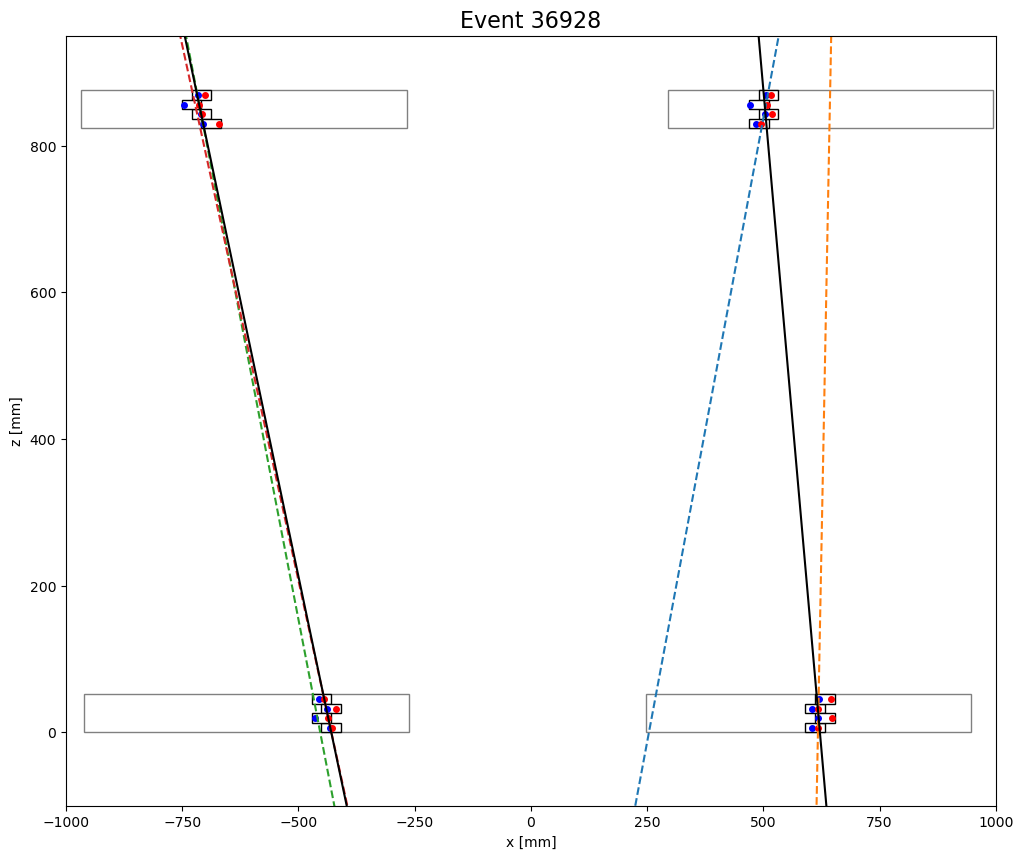

In [35]:
numbers_to_check=[36928]
#numbers_to_check=tricky_events
for number_to_check in numbers_to_check:
    print(cal1[number_to_check])
    print('filter result: ', three_layers_per_det(cal1[number_to_check]))
    event_plotter(number_to_check)


In [36]:
print(events_to_plot)

[13, 1906, 2816, 4830, 4944, 4980, 5299, 5757, 5766, 5893, 6343, 6865, 7826, 8454, 8919, 9977, 10053, 10246, 13538, 13779, 14367, 14506, 14666, 16164, 16283, 16991, 19841, 20132, 20421, 20884, 22039, 22977, 23385, 23616, 25507, 26475, 26545, 26706, 26714, 27287, 27650, 27833, 28706, 28912, 30779, 30937, 31356, 32162, 33946, 35130, 35578, 36414, 36433, 36928, 37042, 38988, 38992, 39120, 39147, 40195, 41017, 41143, 41914, 42211, 42284, 42407, 42520, 43280, 43299, 44728, 44779, 44883, 45079, 45715, 45835, 46430, 46489, 46660, 46927, 47144, 47538, 48677, 48912, 48976, 49972, 51103, 51116, 51523, 51530, 51585, 52674, 53512, 53820, 55721, 56208, 56909, 57799, 57822, 59801, 59978, 61279, 61434, 61450]


In [37]:
previous_events_to_plot=[13, 1906, 2816, 4830, 4944, 4980, 5299, 5757, 5766, 6343, 6865, 8454, 8919, 9977, 10053, 10246, 13538, 13779, 14367, 14506, 14666, 16164, 16283, 16991, 19841, 20132, 20421, 20884, 22039, 22977, 23385, 23616, 25507, 26475, 26545, 26706, 26714, 27287, 27650, 27833, 28706, 28912, 30779, 30937, 31356, 32162, 33946, 35130, 35578, 36414, 36433, 36928, 37042, 38988, 38992, 39120, 39147, 40195, 41017, 41143, 41914, 42211, 42284, 42407, 42520, 43280, 43299, 44728, 44779, 44883, 45079, 45715, 45835, 46430, 46489, 46660, 46927, 47144, 47538, 48677, 48912, 48976, 49972, 51103, 51116, 51523, 51530, 51585, 52674, 53512, 53820, 55721, 56208, 56909, 57799, 59801, 59978, 61279, 61434, 61450]

In [41]:
print(len(events_to_plot), len(previous_events_to_plot), len([event for event in previous_events_to_plot if event in events_to_plot]))

103 100 100
